Y-DATA 2021/21<br/>
Large-scale ML HW2<br/>
Serge Tochilov

In [ ]:
# Checklist:
# AWS emr-5.29.0
# MASTER r5d.8xlarge 1x, no EBS
# CORE r5d.8xlarge 4x, no EBS
# Custom bootstrap action: s3://ydatazian/bootstrap.sh
# Allow ssh in master node security group

> There might be older Numpy versions installed behind the latest, clean that. Add libs missed from `emr-5.29.0` AWS image.

In [ ]:
! sudo pip-3.6 uninstall -y numpy
! sudo pip-3.6 uninstall -y numpy
! sudo pip-3.6 uninstall -y numpy
! sudo pip-3.6 install numpy
! sudo pip-3.6 install pypandoc
! sudo pip-3.6 install pyspark==2.4.8

Uninstalling numpy-1.19.5:
  Successfully uninstalled numpy-1.19.5
You are using pip version 9.0.3, however version 21.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Uninstalling numpy-1.14.5:
  Successfully uninstalled numpy-1.14.5
You are using pip version 9.0.3, however version 21.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Uninstalling numpy-1.14.5:
  Successfully uninstalled numpy-1.14.5
You are using pip version 9.0.3, however version 21.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/45/b2/6c7545bb7a38754d63048c7696804a0d947328125d81bf12beaa692c3ae3/numpy-1.19.5-cp36-cp36m-manylinux1_x86_64.whl
You are using pip version 9.0.3, however version 21.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Running setup.py install for pypandoc ... done
Yo

In [ ]:
import tqdm.notebook as tqdm
import numpy as np
import scipy
import sklearn
import matplotlib.pyplot as plt

# SparkSession

https://spark.apache.org/docs/2.4.4/api/python/pyspark.html

https://spark.apache.org/docs/2.4.4/api/python/pyspark.sql.html

In [ ]:
import findspark
findspark.init()

import spark_utils
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
sc = SparkContext("yarn", "My App", conf=spark_utils.get_spark_conf())
se = SparkSession(sc)
spark_utils.print_ui_links()

NameNode: http://ec2-34-213-182-170.us-west-2.compute.amazonaws.com:50070
YARN: http://ec2-34-213-182-170.us-west-2.compute.amazonaws.com:8088
Spark UI: http://ec2-34-213-182-170.us-west-2.compute.amazonaws.com:20888/proxy/application_1622135603228_0001


## Outbrain click prediction dataseet

https://www.kaggle.com/c/outbrain-click-prediction/data

### AWS S3

In [ ]:
! aws s3 ls s3://ydatazian

                           PRE week1/
2021-05-06 13:10:24       1672 bootstrap.sh
2021-05-13 21:20:22  176843889 clicks_test.parquet
2021-05-13 21:20:22  495815517 clicks_train.parquet
2021-05-13 21:21:58   34267065 documents_categories.parquet
2021-05-13 21:21:58  206455957 documents_entities.parquet
2021-05-13 21:21:58   23859965 documents_meta.parquet
2021-05-13 21:21:58  187410196 documents_topics.parquet
2021-05-13 21:21:58  734643471 events.parquet
2021-05-13 21:56:44 50764611872 page_views.parquet
2021-05-13 21:21:58  248421413 page_views_sample.parquet
2021-05-13 21:21:59    5116927 promoted_content.parquet
2021-05-13 21:21:58  273136709 sample_submission.csv


# Register all tables for sql queries

In [ ]:
tables = ["clicks_test", "clicks_train", 
          "documents_categories", "documents_entities", "documents_meta", "documents_topics", 
          "events", "page_views", "page_views_sample", "promoted_content"]
for name in tqdm.tqdm(tables):
    df = se.read.parquet("s3://ydatazian/{}.parquet".format(name))
    df.registerTempTable(name)
    print(name)
    display(df.limit(3).toPandas())

  0%|          | 0/10 [00:00<?, ?it/s]

clicks_test


,display_id,ad_id
0,16874594,66758
1,16874594,150083
2,16874594,162754


clicks_train


,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1


documents_categories


,document_id,category_id,confidence_level
0,1595802,1611,0.92
1,1595802,1610,0.07
2,1524246,1807,0.92


documents_entities


,document_id,entity_id,confidence_level
0,1524246,f9eec25663db4cd83183f5c805186f16,0.672865314504701
1,1524246,55ebcfbdaff1d6f60b3907151f38527a,0.399113728441297
2,1524246,839907a972930b17b125eb0247898412,0.392095749652966


documents_meta


,document_id,source_id,publisher_id,publish_time
0,1595802,1,603,2016-06-05 00:00:00
1,1524246,1,603,2016-05-26 11:00:00
2,1617787,1,603,2016-05-27 00:00:00


documents_topics


,document_id,topic_id,confidence_level
0,1595802,140,0.0731131601068925
1,1595802,16,0.0594164867373976
2,1595802,143,0.0454207537554526


events


,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505


page_views


,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1


page_views_sample


,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1


promoted_content


,ad_id,document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7


# HW 2 [Optional]. Spark SQL

## Q1 (1 point). Average CTR

Find out the average `uuid` (user) CTR, i.e., number of clicks in all of her `display_ids` / (number of impressions ... + 10). Plot the distribution of individual CTRs as a histogram (`bins=100`).

In [ ]:
sql_ctr = """
    select
        *, click_1 / (click_0 + click_1{bias}) as ctr
    from (
        select
            uuid, clicked, count(*) as view_count
        from (
            select
                events.uuid, clicked
            from
                clicks_train
            inner join
                events
            on
                clicks_train.display_id = events.display_id)
        group by
            uuid, clicked)
    pivot (
        first(view_count)
        for
            clicked in (0 click_0, 1 click_1))
"""

In [ ]:
%%time
df = se.sql(sql_ctr.format(bias=' + 10'))
df.printSchema()

root
 |-- uuid: string (nullable = true)
 |-- click_0: long (nullable = true)
 |-- click_1: long (nullable = true)
 |-- ctr: double (nullable = true)

CPU times: user 1.84 ms, sys: 0 ns, total: 1.84 ms
Wall time: 96 ms


In [ ]:
%%time
display(df.toPandas())

,uuid,click_0,click_1,ctr
0,f57059a117cf76,7,1,0.055556
1,aaca0d62c5e4fd,8,2,0.100000
2,bcc5aa3d8042bc,8,3,0.142857
3,cb141fad5e696a,5,1,0.062500
4,2a358c38f76833,3,1,0.071429
...,...,...,...,...
14814339,8f3d748714cc0c,10,2,0.090909
14814340,bf748b0eda152b,4,1,0.066667
14814341,53e03f22b28b7e,3,1,0.071429
14814342,851f5d238be8bb,4,2,0.125000


CPU times: user 53.8 s, sys: 2.79 s, total: 56.6 s
Wall time: 1min 52s


In [ ]:
%%time
ctr_10_hist = np.histogram(np.array(df.select('ctr').collect()), bins=100)

CPU times: user 3min 8s, sys: 1.5 s, total: 3min 9s
Wall time: 3min 55s


In [ ]:
def plot_hist(hist, plot_type='hist'):
    
    plt.figure()
    
    if plot_type == 'hist':
        plt.plot(0.5 * (hist[1][1:] + hist[1][:-1]), hist[0])
    elif plot_type == 'scatter':
        plt.scatter(hist[0], hist[1])
        
    plt.xscale('log')
    plt.yscale('log')
    plt.grid()
    plt.show()

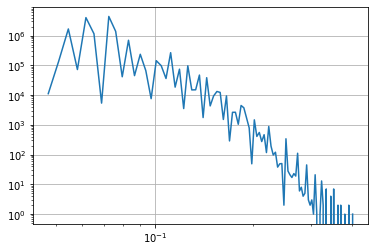

In [ ]:
plot_hist(ctr_10_hist)

> The biased CTR distribution has an approximate power-law distribution, i.e. high-rate "clickers" are exceedingly rare. Let's also check the unbiased CTR.

In [ ]:
%%time
df = se.sql(sql_ctr.format(bias=''))
df.printSchema()

root
 |-- uuid: string (nullable = true)
 |-- click_0: long (nullable = true)
 |-- click_1: long (nullable = true)
 |-- ctr: double (nullable = true)

CPU times: user 1.77 ms, sys: 0 ns, total: 1.77 ms
Wall time: 28.5 ms


In [ ]:
%%time
display(df.toPandas())

,uuid,click_0,click_1,ctr
0,ea8602cd3bc87c,3,1,0.250000
1,888664656d26e9,5,1,0.166667
2,53f4534912289a,5,1,0.166667
3,6e2a9fea163f61,3,1,0.250000
4,b3ff4734a03103,8,1,0.111111
...,...,...,...,...
14814339,bdce0805317ce4,3,1,0.250000
14814340,13ae00ad5365ab,5,1,0.166667
14814341,3cfc254b528853,5,1,0.166667
14814342,d3645c95525ec5,7,1,0.125000


CPU times: user 54.6 s, sys: 2.76 s, total: 57.3 s
Wall time: 1min 52s


In [ ]:
%%time
ctr_hist = np.histogram(np.array(df.select('ctr').collect()), bins=100)

CPU times: user 3min 8s, sys: 1.59 s, total: 3min 9s
Wall time: 3min 53s


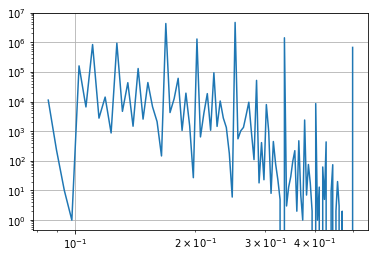

In [ ]:
plot_hist(ctr_hist)

> We see that the biasing CTR denominator is kind of Laplacian regularization that smooths the CTR distribution.

## Q2 (1 point). Page views

Find out how many page views an average user has, before encountering a `display_id` (use `timestamp` columns). Plot the distribution of individual values.

> For analysis we select only rows having common `uuid` in both `page_views` and `events`, i.e., we compute statistics per user. Also, we consider all documents viewed by user.by disregarding `document_is`.

In [ ]:
df = se.sql(
"""
    select
        page_views.uuid,
        count(*) as views_before
    from
        page_views
    inner join (
        select
            uuid,
            min(cast(events.timestamp as int)) as min_ts
        from
            events
        group by
            uuid) as min_events
    on
        page_views.uuid = min_events.uuid
    where
        cast(page_views.timestamp as int) < min_events.min_ts
    group by
        page_views.uuid
""")
df.printSchema()

root
 |-- uuid: string (nullable = true)
 |-- views_before: long (nullable = false)



In [ ]:
%%time
views_before = np.array(df.select('views_before').collect()).ravel()
print(np.mean(views_before))

5.921887909562661
CPU times: user 3min 2s, sys: 1.48 s, total: 3min 3s
Wall time: 14min 20s


> An average user views $\sim6$ pages before encountering an ad.

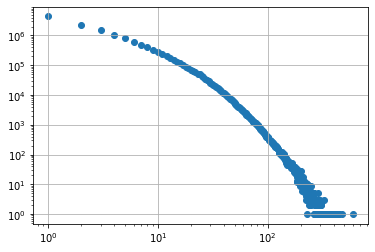

In [ ]:
views_before_hist = np.bincount(views_before)
v_range = np.argwhere(views_before_hist)
plot_hist((v_range, views_before_hist[v_range]), plot_type='scatter')

> Like CTR, the views before ad distribution is an approximate power-law, but now the deviation from pure power-law is much more evident.